In [1]:
import os
import time

import dill as pickle

from datetime import datetime, timedelta

import numpy as np
import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
import matplotlib.pyplot as plt

sys.path.append('../')
from data import nCovid19Deaths

import warnings
warnings.simplefilter('ignore')

DATESTAMP_LABEL = '2020_03_30'

# just use generic name since the location names include non-alphanumeric characters  # -l archive=TRUE 
QSUB_STR = 'qsub -N curve_model_{location_id} -P proj_covid -q d.q -l m_mem_free=3G -l fthread=3 -o omp_num_threads=3 '\
    '{code_dir}/mr_brt_refactor_env.sh {code_dir}/model.py '\
    '--model_location {model_location} --data_file {data_file} --cov_file {cov_file} --output_dir {output_dir}'
CODE_DIR = os.path.abspath('')
OUTPUT_DIR = f'/ihme/covid-19/deaths/counterfactual/{DATESTAMP_LABEL}'
CASE_DIR = f'/ihme/covid-19/deaths/counterfactual/cases_{DATESTAMP_LABEL}'
DEATH_FILE = f'/ihme/code/dbd/hkl1/covid_19_model/model_data/state_data_{DATESTAMP_LABEL}.csv'

if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)
print(f'Writing to {OUTPUT_DIR}')


/ihme/code/evidence_score/miniconda3/envs/mr_brt_refactor_env/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Writing to /ihme/covid-19/deaths/counterfactual/2020_03_30


## read in case and death data

In [2]:
# daily cases
locations = [i[:-4] for i in os.listdir(CASE_DIR) if i.endswith('.csv')]
case_df = pd.concat([
    pd.read_csv(f'{CASE_DIR}/{location}.csv') for location in locations
]).reset_index(drop=True)
case_df['date'] = case_df['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
case_df['cases'] = case_df[[f'draw_{i}' for i in range(1000)]].mean(axis=1)
case_df = case_df[['location', 'date', 'cases']]
case_df = case_df.sort_values(['location', 'date']).reset_index(drop=True)

# cumulative deaths
death_draws_df = pd.read_csv(DEATH_FILE)
death_draws_df['date'] = death_draws_df['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
death_df = death_draws_df.copy()
death_df['deaths'] = death_df[[f'draw_{i}' for i in range(1000)]].mean(axis=1)
death_df = death_df[['location', 'date', 'deaths']]
death_df = death_df.sort_values(['location', 'date']).reset_index(drop=True)


In [3]:
def get_upswing_deaths(location, loc_case_df, loc_death_df):
    may1_cases = loc_case_df.loc[loc_case_df['date'] == datetime.strptime('2020-05-01', '%Y-%m-%d'), 'cases'].item()

    if may1_cases >= 1:
        ## get date of that number of cases on upswing:
        ##     find peak, get diff in cases before that time, argmin
        peak_idx = loc_case_df['cases'].values.argmax()
        upswing_date = loc_case_df.iloc[np.abs(loc_case_df['cases'].values - may1_cases)[:peak_idx].argmin()]['date']
        upswing_cases = loc_case_df.iloc[np.abs(loc_case_df['cases'].values - may1_cases)[:peak_idx].argmin()]['cases']
        loc_death_df = loc_death_df.loc[loc_death_df['date'] <= upswing_date]
        if len(loc_death_df) > 0:
            # fix if estimate is < truth (can happen if below threshold)
            loc_death_df.loc[loc_death_df['deaths'] < loc_death_df['deaths'].values[0], 'deaths'] = loc_death_df['deaths'].values[0]
            if loc_death_df['deaths'].min() == loc_death_df['deaths'].max():
                print(f'No change in deaths for {location}')
                loc_death_df = loc_death_df.loc[loc_death_df['deaths'] < loc_death_df['deaths'].min()]
        ## make a picture
        # plt.plot(loc_case_df['date'], loc_case_df['cases'], color='blue')
        # plt.axhline(may1_cases, color='green', alpha=0.75, linestyle='--')
        # plt.axhline(upswing_cases, color='red', alpha=0.75, linestyle='--')
        # plt.axvline(datetime.strptime('2020-05-01', '%Y-%m-%d'), color='green', alpha=0.75, linestyle='--')
        # plt.axvline(upswing_date, color='red', alpha=0.75, linestyle='--')
        # plt.title(location)
        # plt.show()
    else:
        print(f'No new cases on May 1 for {location}')
        loc_death_df = pd.DataFrame(columns=loc_death_df.columns)
    
    # convert to days
    loc_death_df['days'] = loc_death_df['date'].apply(lambda x: (x - loc_death_df['date'].min()).days)
    
    return loc_death_df

# do the thing
upswing_df = pd.concat([
    get_upswing_deaths(
        location=location,
        loc_case_df=case_df.loc[case_df['location'] == location].reset_index(drop=True),
        loc_death_df=death_df.loc[death_df['location'] == location].reset_index(drop=True)
    ) for location in locations
]).reset_index(drop=True)


No change in deaths for Hawaii
No new cases on May 1 for Life Care Center, Kirkland, WA
No new cases on May 1 for New Jersey
No change in deaths for Nebraska
No change in deaths for West Virginia
No new cases on May 1 for District of Columbia
No change in deaths for Utah
No new cases on May 1 for Michigan
No new cases on May 1 for Vermont
No new cases on May 1 for Louisiana
No new cases on May 1 for Connecticut
No change in deaths for South Dakota
No new cases on May 1 for New York
No change in deaths for South Carolina
No new cases on May 1 for Massachusetts


## get necessary info for model

In [4]:
data = nCovid19Deaths(data_version='best')
data.collect_data()
pop_df = data.age_pop_df.merge(data.df[['location_id', 'Province/State']].drop_duplicates())
del data
pop_df = pop_df.rename(index=str, columns={'Province/State':'location'})
pop_df = pop_df.groupby(['location_id', 'location'], as_index=False)['population'].sum()
upswing_df = upswing_df.merge(pop_df)
del pop_df
upswing_df['ln(age-standardized death rate)'] = np.log(upswing_df['deaths'] / upswing_df['population'])
upswing_df = upswing_df.rename(
    index=str,
    columns={'location':'Location',
             'deaths':'Deaths',
             'days':'Days',
             'date':'Date'}
)
pd.merge(
    upswing_df.groupby('Location', as_index=False)['Days'].count(),
    upswing_df.groupby('Location', as_index=False)['ln(age-standardized death rate)'].min()
)


No location_id for , Aruba, Cape Verde, Cayman Islands, Channel Islands, Cruise Ship, Curacao, Diamond Princess, East Timor, Faroe Islands, French Guiana, Gibraltar, Guadeloupe, Guernsey, Jersey, Liechtenstein, MS Zaandam, Martinique, Mayotte, Others, Reunion, Saint Barthelemy, Saint Martin, United States of America.


,Location,Days,ln(age-standardized death rate)
0,California,17,-17.501186
1,Florida,26,-16.175180
2,Idaho,4,-13.267974
3,Kansas,9,-14.903974
4,Kentucky,39,-15.320671
5,Maryland,9,-15.630718
6,Missouri,44,-15.646964
7,New Mexico,9,-14.597383
8,North Dakota,8,-13.470552
9,Oregon,21,-15.209354


## run model

In [5]:
def submit_curvefit(location_id, model_location, data_file, cov_file, output_dir):
    qsub_str = QSUB_STR.format(
        location_id=location_id,
        code_dir=CODE_DIR,
        model_location=model_location.replace(' ', '\ ').replace('(', '\(').replace(')', '\)'),
        data_file=data_file.replace(' ', '\ ').replace('(', '\(').replace(')', '\)'),
        cov_file=cov_file.replace(' ', '\ ').replace('(', '\(').replace(')', '\)'),
        output_dir=output_dir.replace(' ', '\ ').replace('(', '\(').replace(')', '\)')
    )
    
    job_str = os.popen(qsub_str).read()
    print(job_str)

model_out_dir = f'{OUTPUT_DIR}/model_data'
if not os.path.exists(model_out_dir):
    os.mkdir(model_out_dir)

# store deaths (ONLY KEEP ABOVE THRESHOLD!!!!)
upswing_df = upswing_df.loc[upswing_df['ln(age-standardized death rate)'] >= -15]
upswing_df.to_csv(f'{model_out_dir}/us_deaths.csv', index=False)

# create dummy covariate file
cov_df = upswing_df[['Location']].drop_duplicates()
cov_df['cov_1w'] = 1
cov_df.to_csv(f'{model_out_dir}/us_cov.csv', index=False)

# # run model
# if not os.path.exists(f'{model_out_dir}/us'):
#     os.mkdir(f'{model_out_dir}/us')
# submit_curvefit(102, 
#                 model_location='United States of America',
#                 data_file=f'{model_out_dir}/us_deaths.csv', 
#                 cov_file=f'{model_out_dir}/us_cov.csv', 
#                 output_dir=f'{model_out_dir}/us')


## load model and compile draws

In [14]:
# read model outputs
while not os.path.exists(f'{model_out_dir}/us/death_model.pkl'):
    print(f'    Waiting for death model...')
    time.sleep(30)
with open(f'{model_out_dir}/us/death_model.pkl', 'rb') as fread:
    death_model = pickle.load(fread)
    
# get draws for each location
draw_dfs = []

for location_id, location in zip(upswing_df['location_id'].unique(), upswing_df['Location'].unique()):
    days = death_model.beta['draws'][f'_{location_id}'][0]
    days = days - days.min()
    draws = np.vstack([death_model.beta['draws'][f'_{location_id}'][1], 
                       death_model.p['draws'][f'_{location_id}'][1]])
    draws = draws[np.argsort(draws[:,-1]),:]
    draw_df = pd.DataFrame(np.exp(draws.T) * upswing_df.loc[upswing_df['location_id'] == location_id, 'population'].values[0],
                           columns=[f'draw_{i}' for i in range(1000)])
    draw_df['date'] = [pd.Timestamp('2020-05-01') + np.timedelta64(d,'D') for d in days]
    draw_df = draw_df.loc[draw_df['date'] <= pd.Timestamp('2020-07-15')]
    draw_df['location_id'] = location_id
    draw_df['location'] = location
    draw_df['observed'] = False
    draw_dfs.append(draw_df)
draw_df = pd.concat(draw_dfs)


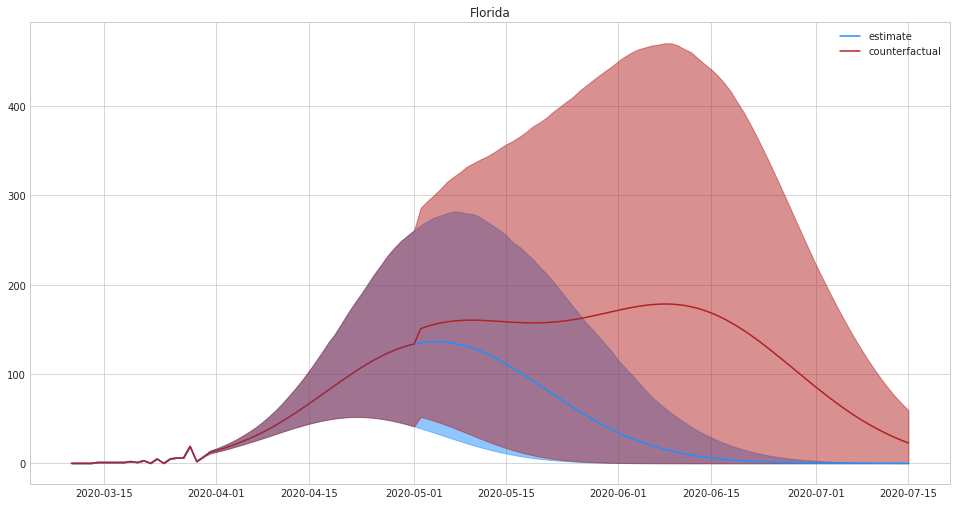

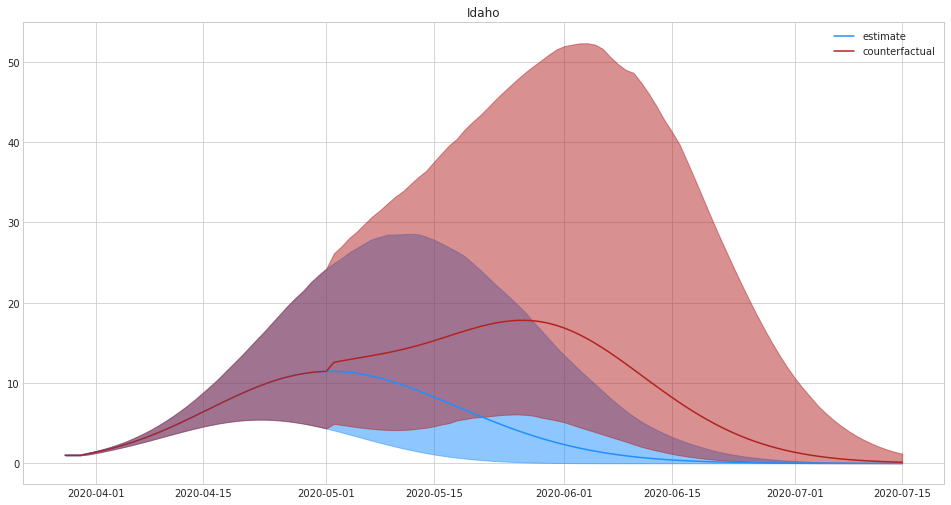

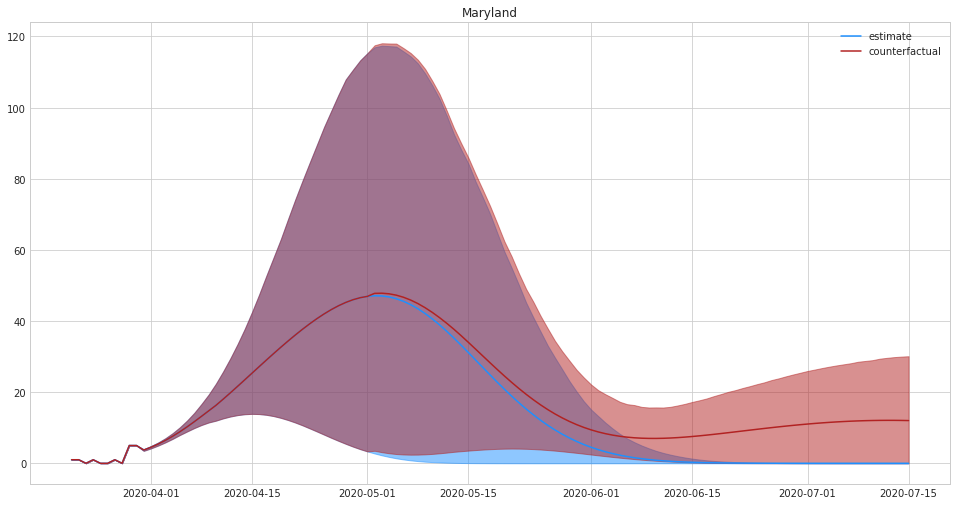

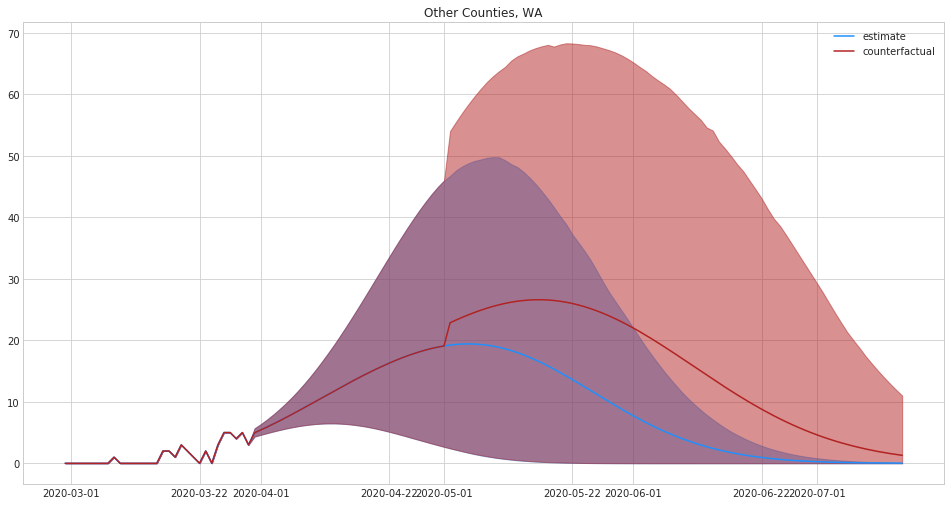

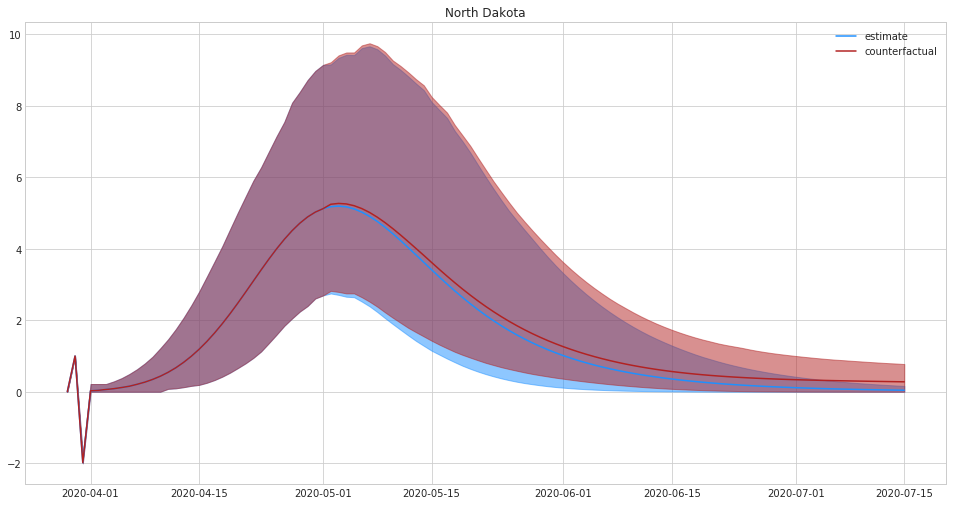

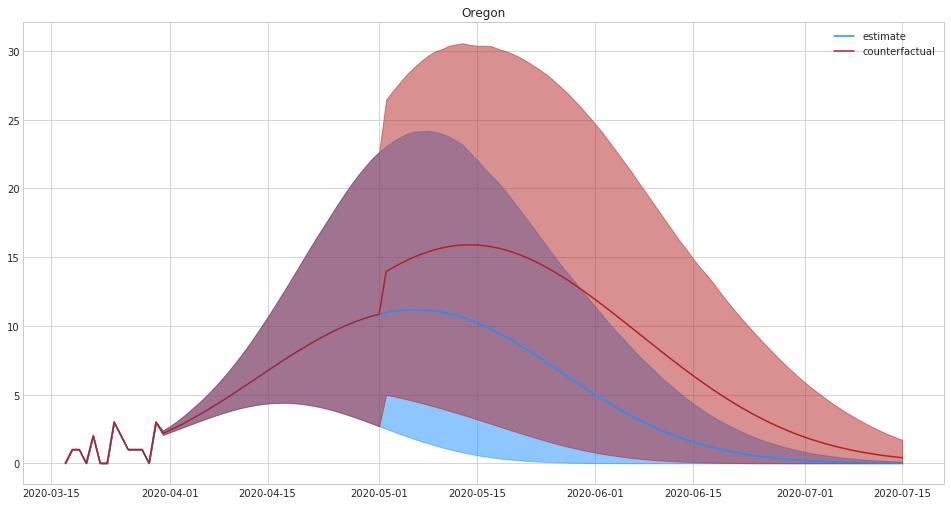

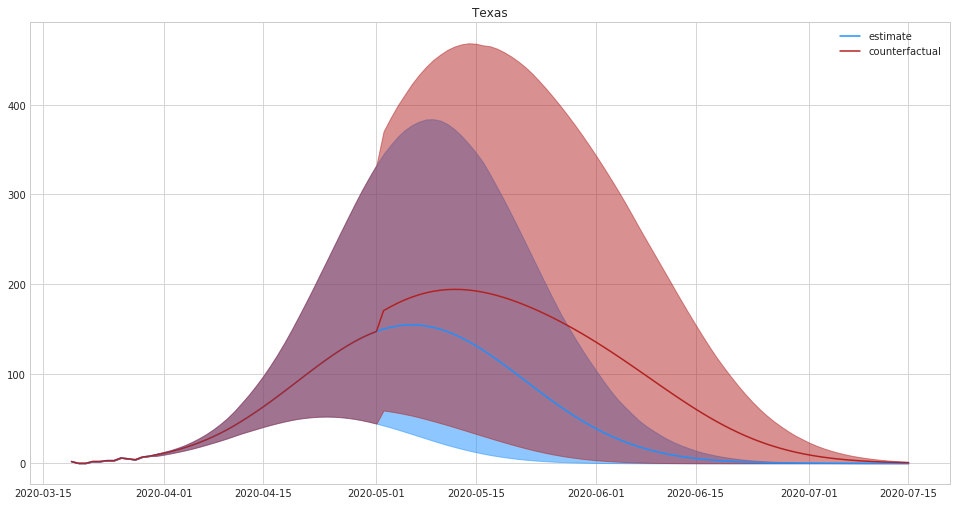

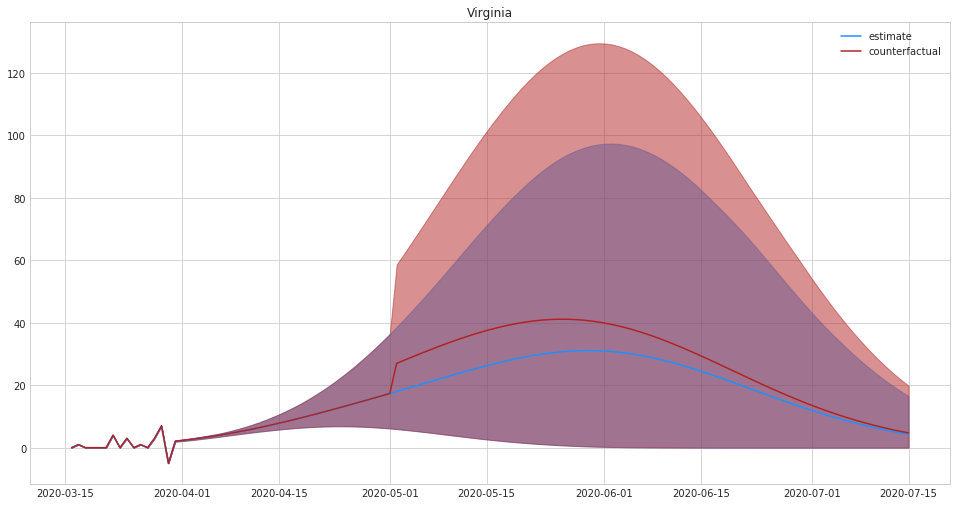

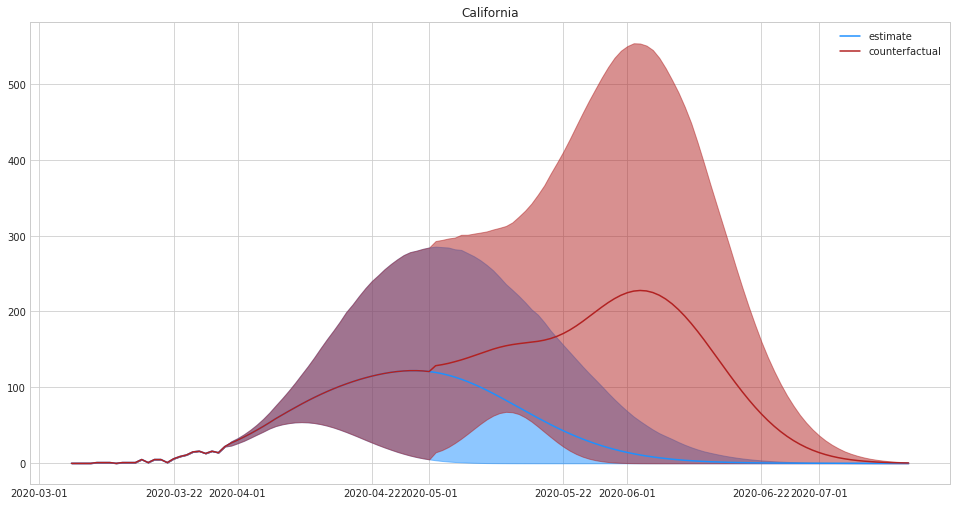

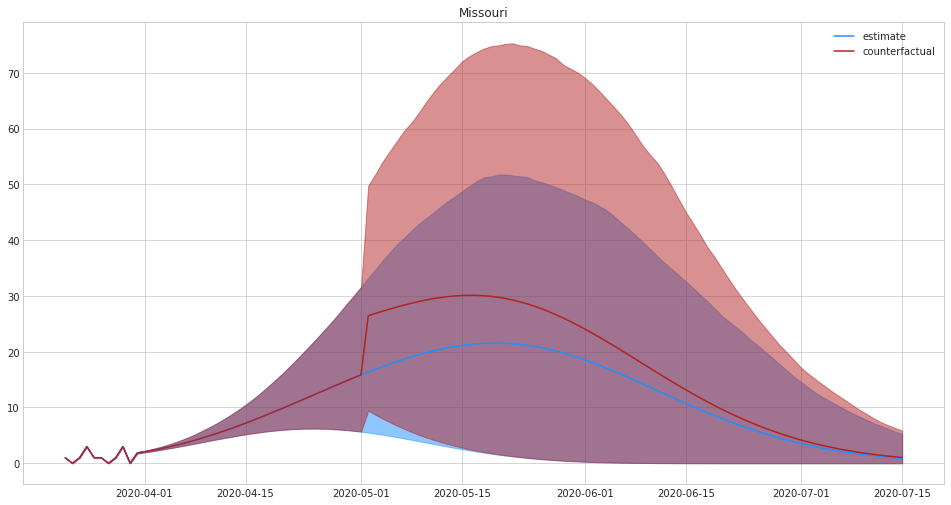

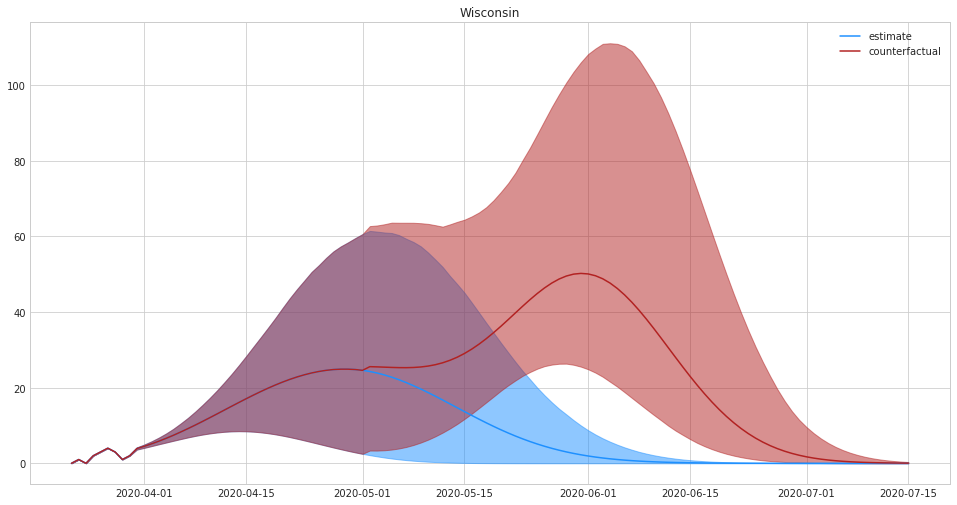

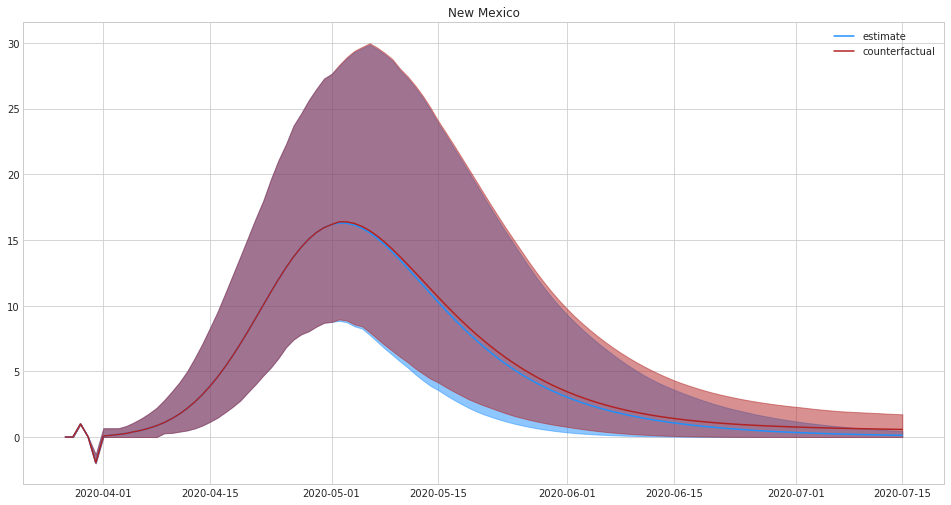

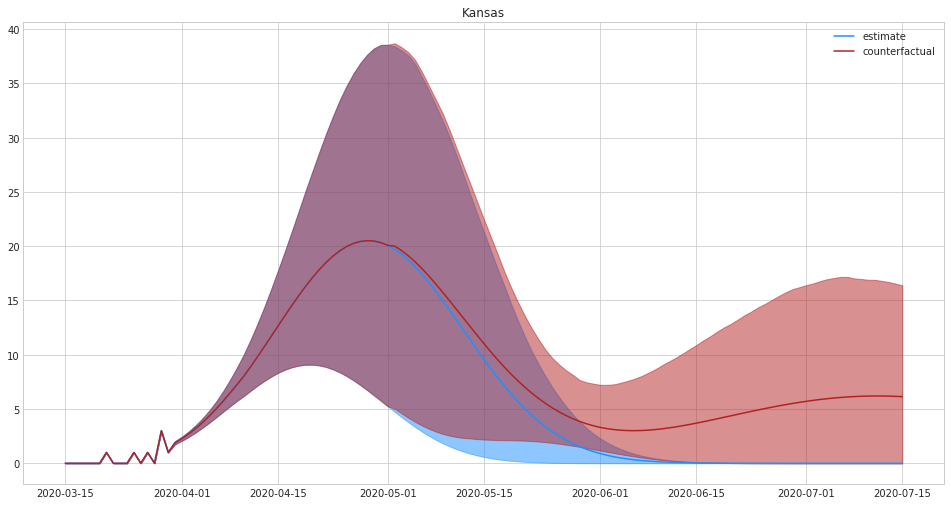

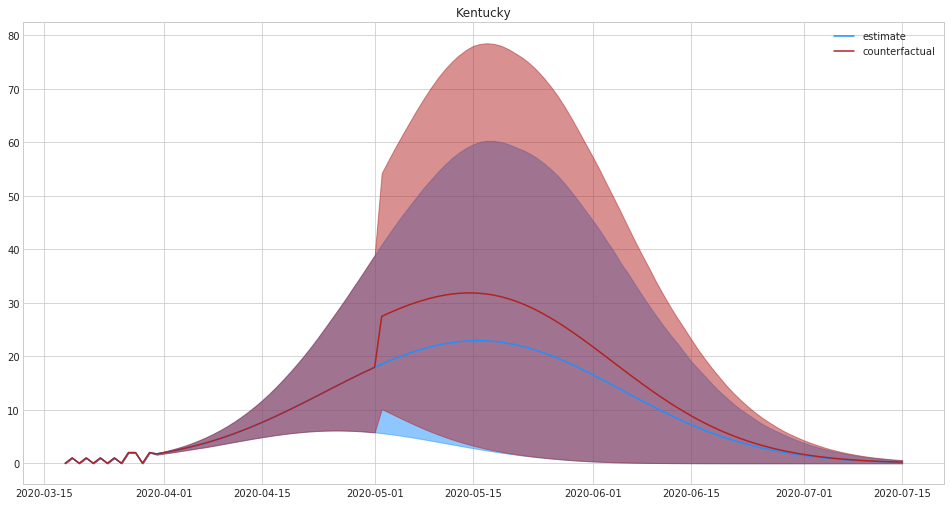

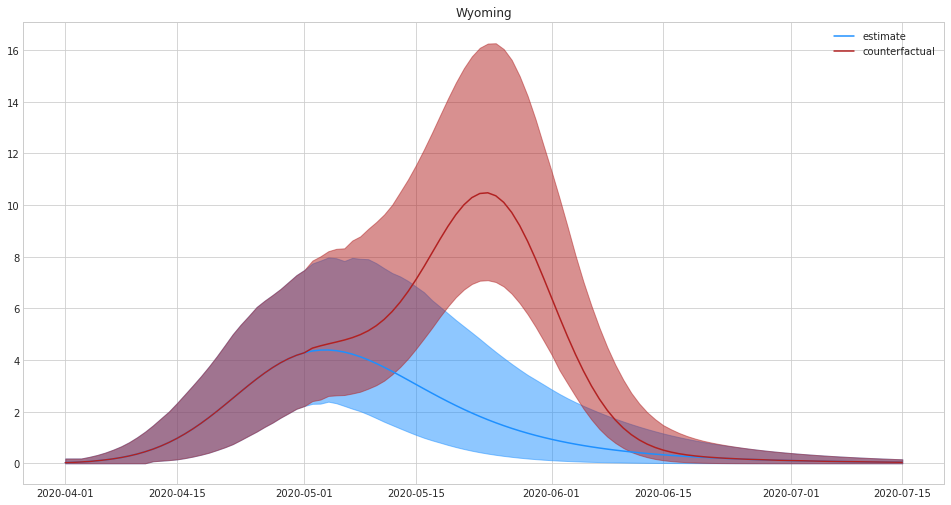

In [15]:
def get_daily(ddf, draw_cols=[f'draw_{i}' for i in range(1000)]):
    ddf = ddf.sort_values('date').reset_index(drop=True)
    daily = ddf[draw_cols].values[1:,:] - ddf[draw_cols].values[:-1,:]
    ddf = ddf.iloc[1:]
    ddf[draw_cols] = daily

    return ddf.reset_index(drop=True)

for location in upswing_df['Location'].unique():
    pub_df = get_daily(death_draws_df.loc[death_draws_df['location'] == location])
    cf_df = get_daily(draw_df.loc[draw_df['location'] == location])
    
    cf_df = pub_df.append(cf_df[pub_df.columns]).reset_index(drop=True)
    cf_df = cf_df.groupby(['location', 'date'], as_index=False)[[f'draw_{i}' for i in range(1000)]].sum()
    
    pub_df['daily_mean'] = pub_df[[f'draw_{i}' for i in range(1000)]].mean(axis=1)
    pub_df['daily_lower'] = np.percentile(pub_df[[f'draw_{i}' for i in range(1000)]], 2.5, axis=1)
    pub_df['daily_upper'] = np.percentile(pub_df[[f'draw_{i}' for i in range(1000)]], 97.5, axis=1)
    
    cf_df['daily_mean'] = cf_df[[f'draw_{i}' for i in range(1000)]].mean(axis=1)
    cf_df['daily_lower'] = np.percentile(cf_df[[f'draw_{i}' for i in range(1000)]], 2.5, axis=1)
    cf_df['daily_upper'] = np.percentile(cf_df[[f'draw_{i}' for i in range(1000)]], 97.5, axis=1)

    pub_df = get_daily(pub_df)
    cf_df = get_daily(cf_df)

    plt.figure(figsize=(16.5, 8.5))
    plt.fill_between(pub_df['date'],
                     pub_df['daily_lower'], pub_df['daily_upper'],
                     color='dodgerblue', alpha=0.5)
    plt.plot(pub_df['date'],
             pub_df['daily_mean'],
             color='dodgerblue', label='estimate')
    plt.fill_between(cf_df['date'],
                     cf_df['daily_lower'], cf_df['daily_upper'],
                     color='firebrick', alpha=0.5)
    plt.plot(cf_df['date'],
             cf_df['daily_mean'],
             color='firebrick', label='counterfactual')
    plt.legend()
    plt.title(location)
    plt.show()
